In [14]:
# ----------------------------
# 1) Dataset: (N,1,5000,12) -> (12,5000)
# ----------------------------
from scipy.signal import medfilt, iirnotch, filtfilt, butter, resample
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader

class ECG12Lead(Dataset):
    def __init__(self, data_npy_root, split):
        split_dir = os.path.join(data_npy_root, split)
        ecg_path = os.path.join(split_dir, f"ecg_{split}.npy")
        self.ecg = np.load(ecg_path)                # shape: (N, 1, 5000, 12)
        self.input_leads = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        self.new_leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] # leads of MIMIC-ECG are different with leads of HEEDB
        self.lead_indices = [self.input_leads.index(lead) for lead in self.new_leads]
        
    def __len__(self): 
        return self.ecg.shape[0]

    def z_score_normalization(self,signal):
        return (signal - np.mean(signal)) / (np.std(signal) +1e-8) 

    def filter_bandpass(self, signal, fs):
        """
        Bandpass filter
        :param signal: 2D numpy array of shape (channels, time)
        :param fs: sampling frequency
        :return: filtered signal
        """
        # Remove power-line interference
        b, a = iirnotch(50, 30, fs)
        filtered_signal = np.zeros_like(signal)
        for c in range(signal.shape[0]):
            filtered_signal[c] = filtfilt(b, a, signal[c])

        # Simple bandpass filter
        b, a = butter(N=4, Wn=[0.67, 40], btype='bandpass', fs=fs)
        for c in range(signal.shape[0]):
            filtered_signal[c] = filtfilt(b, a, filtered_signal[c])

        # Remove baseline wander
        baseline = np.zeros_like(filtered_signal)
        for c in range(filtered_signal.shape[0]):
            kernel_size = int(0.4 * fs) + 1
            if kernel_size % 2 == 0:
                kernel_size += 1  # Ensure kernel size is odd
            baseline[c] = medfilt(filtered_signal[c], kernel_size=kernel_size)
        filter_ecg = filtered_signal - baseline

        return filter_ecg

    def __getitem__(self, idx):
        x = self.ecg[idx, 0]          # (5000,12)
        x = x.T                       # (12,5000)
        x = x[self.lead_indices, :]
        x = x.astype(np.float32)
        x = self.filter_bandpass(x, fs=500)
        # Standardization
        x = self.z_score_normalization(x)
        return torch.from_numpy(x)

train_ecg_ds = ECG12Lead(data_npy_root="../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy", split="train")
val_ecg_ds = ECG12Lead(data_npy_root="../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy", split="val")
test_ecg_ds = ECG12Lead(data_npy_root="../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy", split="test")


In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ecg_ds, batch_size=64, shuffle=False)
val_loader = DataLoader(val_ecg_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ecg_ds, batch_size=64, shuffle=False)

In [16]:
batch = next(iter(test_loader))

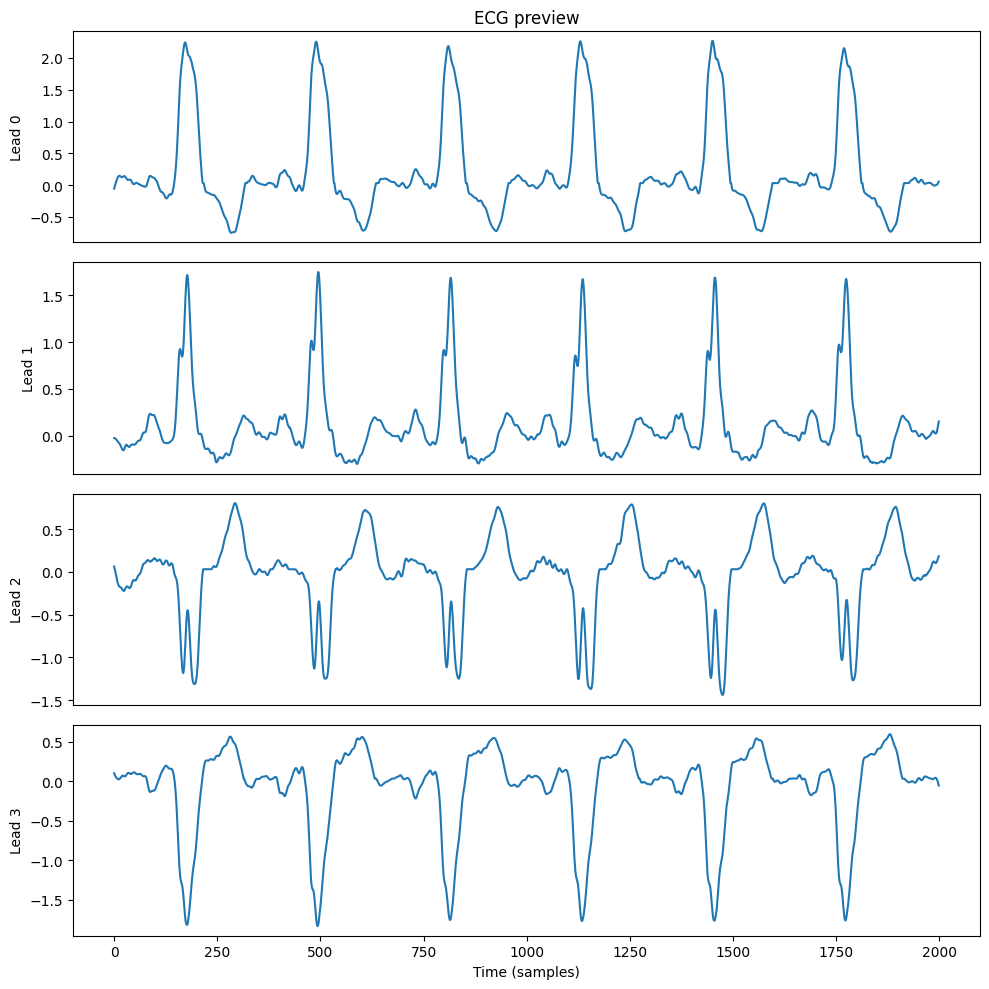

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_ecg_sample(sample, leads_to_plot=(0, 1, 2), max_points=2000):
    ecg = sample.numpy()   # (12, 5000)
    ecg = ecg.T                  # (5000, 12)

    length = min(ecg.shape[0], max_points)
    t = np.arange(length)  # if you know sampling rate fs, use t = np.arange(length)/fs

    n_leads = len(leads_to_plot)
    plt.figure(figsize=(10, 2.5 * n_leads))

    for i, lead in enumerate(leads_to_plot, 1):
        plt.subplot(n_leads, 1, i)
        plt.plot(t, ecg[:length, lead])
        plt.ylabel(f"Lead {lead}")
        if i == 1:
            plt.title("ECG preview")
        if i != n_leads:
            plt.xticks([])
    plt.xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

sample = test_ecg_ds[0]

plot_ecg_sample(sample, leads_to_plot=(0, 1, 2, 3, ))

In [18]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download("PKUDigitalHealth/ECGFounder", "12_lead_ECGFounder.pth")  # :contentReference[oaicite:5]{index=5}


In [19]:
"""
a modularized deep neural network for 1-d signal data, pytorch version
 
Shenda Hong, Mar 2020
"""

import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return (torch.tensor(self.data[index], dtype=torch.float), torch.tensor(self.label[index], dtype=torch.long))

    def __len__(self):
        return len(self.data)

class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding

    input: (n_sample, in_channels, n_length)
    output: (n_sample, out_channels, (n_length+stride-1)//stride)
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        # print(net.shape)
        net = self.conv(net)

        return net
        
class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding

    params:
        kernel_size: kernel size
        stride: the stride of the window. Default value is kernel_size
    
    input: (n_sample, n_channel, n_length)
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        p = max(0, self.kernel_size - 1)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net
    
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class BasicBlock(nn.Module):
    """
    Basic Block: 
        conv1 -> convk -> conv1

    params:
        in_channels: number of input channels
        out_channels: number of output channels
        ratio: ratio of channels to out_channels
        kernel_size: kernel window length
        stride: kernel step size
        groups: number of groups in convk
        downsample: whether downsample length
        use_bn: whether use batch_norm
        use_do: whether use dropout

    input: (n_sample, in_channels, n_length)
    output: (n_sample, out_channels, (n_length+stride-1)//stride)
    """
    def __init__(self, in_channels, out_channels, ratio, kernel_size, stride, groups, downsample, is_first_block=False, use_bn=True, use_do=True):
        super(BasicBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.groups = groups
        self.downsample = downsample
        self.stride = stride if self.downsample else 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        self.middle_channels = int(self.out_channels * self.ratio)

        # the first conv, conv1
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.activation1 = Swish()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=self.in_channels, 
            out_channels=self.middle_channels, 
            kernel_size=1, 
            stride=1,
            groups=1)

        # the second conv, convk
        self.bn2 = nn.BatchNorm1d(self.middle_channels)
        self.activation2 = Swish()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=self.middle_channels, 
            out_channels=self.middle_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the third conv, conv1
        self.bn3 = nn.BatchNorm1d(self.middle_channels)
        self.activation3 = Swish()
        self.do3 = nn.Dropout(p=0.5)
        self.conv3 = MyConv1dPadSame(
            in_channels=self.middle_channels, 
            out_channels=self.out_channels, 
            kernel_size=1, 
            stride=1,
            groups=1)

        # Squeeze-and-Excitation
        r = 2
        self.se_fc1 = nn.Linear(self.out_channels, self.out_channels//r)
        self.se_fc2 = nn.Linear(self.out_channels//r, self.out_channels)
        self.se_activation = Swish()

        if self.downsample:
            self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        out = x
        # the first conv, conv1
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.activation1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv, convk
        if self.use_bn:
            out = self.bn2(out)
        out = self.activation2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)
        
        # the third conv, conv1
        if self.use_bn:
            out = self.bn3(out)
        out = self.activation3(out)
        if self.use_do:
            out = self.do3(out)
        out = self.conv3(out) # (n_sample, n_channel, n_length)

        # Squeeze-and-Excitation
        se = out.mean(-1) # (n_sample, n_channel)
        se = self.se_fc1(se)
        se = self.se_activation(se)
        se = self.se_fc2(se)
        se = torch.sigmoid(se) # (n_sample, n_channel)
        out = torch.einsum('abc,ab->abc', out, se)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out

class BasicStage(nn.Module):
    """
    Basic Stage:
        block_1 -> block_2 -> ... -> block_M
    """
    def __init__(self, in_channels, out_channels, ratio, kernel_size, stride, groups, i_stage, m_blocks, use_bn=True, use_do=True, verbose=False):
        super(BasicStage, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.groups = groups
        self.i_stage = i_stage
        self.m_blocks = m_blocks
        self.use_bn = use_bn
        self.use_do = use_do
        self.verbose = verbose

        self.block_list = nn.ModuleList()
        for i_block in range(self.m_blocks):
            
            # first block
            if self.i_stage == 0 and i_block == 0:
                self.is_first_block = True
            else:
                self.is_first_block = False
            # downsample, stride, input
            if i_block == 0:
                self.downsample = True
                self.stride = stride
                self.tmp_in_channels = self.in_channels
            else:
                self.downsample = False
                self.stride = 1
                self.tmp_in_channels = self.out_channels
            
            # build block
            tmp_block = BasicBlock(
                in_channels=self.tmp_in_channels, 
                out_channels=self.out_channels, 
                ratio=self.ratio, 
                kernel_size=self.kernel_size, 
                stride=self.stride, 
                groups=self.groups, 
                downsample=self.downsample, 
                is_first_block=self.is_first_block,
                use_bn=self.use_bn, 
                use_do=self.use_do)
            self.block_list.append(tmp_block)

    def forward(self, x):

        out = x

        for i_block in range(self.m_blocks):
            net = self.block_list[i_block]
            out = net(out)
            if self.verbose:
                print('stage: {}, block: {}, in_channels: {}, out_channels: {}, outshape: {}'.format(self.i_stage, i_block, net.in_channels, net.out_channels, list(out.shape)))
                print('stage: {}, block: {}, conv1: {}->{} k={} s={} C={}'.format(self.i_stage, i_block, net.conv1.in_channels, net.conv1.out_channels, net.conv1.kernel_size, net.conv1.stride, net.conv1.groups))
                print('stage: {}, block: {}, convk: {}->{} k={} s={} C={}'.format(self.i_stage, i_block, net.conv2.in_channels, net.conv2.out_channels, net.conv2.kernel_size, net.conv2.stride, net.conv2.groups))
                print('stage: {}, block: {}, conv1: {}->{} k={} s={} C={}'.format(self.i_stage, i_block, net.conv3.in_channels, net.conv3.out_channels, net.conv3.kernel_size, net.conv3.stride, net.conv3.groups))

        return out

class Net1D(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    params:
        in_channels
        base_filters
        filter_list: list, filters for each stage
        m_blocks_list: list, number of blocks of each stage
        kernel_size
        stride
        groups_width
        n_stages
        n_classes
        use_bn
        use_do

    """

    def __init__(self, in_channels, base_filters, ratio, filter_list, m_blocks_list, kernel_size, stride, groups_width, n_classes, use_bn=True, use_do=True, return_features=False, verbose=False):
        super(Net1D, self).__init__()
        
        self.in_channels = in_channels
        self.base_filters = base_filters
        self.ratio = ratio
        self.filter_list = filter_list
        self.m_blocks_list = m_blocks_list
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups_width = groups_width
        self.n_stages = len(filter_list)
        self.n_classes = n_classes
        self.use_bn = use_bn
        self.use_do = use_do
        self.return_features = return_features
        self.verbose = verbose

        # first conv
        self.first_conv = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=self.base_filters, 
            kernel_size=self.kernel_size, 
            stride=2)
        self.first_bn = nn.BatchNorm1d(base_filters)
        self.first_activation = Swish()

        # stages
        self.stage_list = nn.ModuleList()
        in_channels = self.base_filters
        for i_stage in range(self.n_stages):

            out_channels = self.filter_list[i_stage]
            m_blocks = self.m_blocks_list[i_stage]
            tmp_stage = BasicStage(
                in_channels=in_channels, 
                out_channels=out_channels, 
                ratio=self.ratio, 
                kernel_size=self.kernel_size, 
                stride=self.stride, 
                groups=out_channels//self.groups_width, 
                i_stage=i_stage,
                m_blocks=m_blocks, 
                use_bn=self.use_bn, 
                use_do=self.use_do, 
                verbose=self.verbose)
            self.stage_list.append(tmp_stage)
            in_channels = out_channels

        # final prediction
        self.dense = nn.Linear(in_channels, n_classes)
        
    def forward(self, x):
        
        out = x
        
        # first conv
        out = self.first_conv(out)
        if self.use_bn:
            out = self.first_bn(out)
        out = self.first_activation(out)
        
        # stages
        for i_stage in range(self.n_stages):
            net = self.stage_list[i_stage]
            out = net(out)

        # final prediction
        deep_features = out.mean(-1)
        out = self.dense(deep_features)

        if self.return_features:
            return out, deep_features
        else:
            return out

if __name__ == "__main__":
  model = Net1D(
      in_channels=12, 
      base_filters=64, #32 64
      ratio=1, 
      filter_list=[64,160,160,400,400,1024,1024],    #[16,32,32,80,80,256,256] [32,64,64,160,160,512,512] [64,160,160,400,400,1024,1024]
      m_blocks_list=[2,2,2,3,3,4,4],   #[2,2,2,2,2,2,2] [2,2,2,3,3,4,4]
      kernel_size=16, 
      stride=2, 
      groups_width=16,
      verbose=True, 
      use_bn=False,
      use_do=False,
      n_classes=150)
  print(model)

Net1D(
  (first_conv): MyConv1dPadSame(
    (conv): Conv1d(12, 64, kernel_size=(16,), stride=(2,))
  )
  (first_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Swish()
  (stage_list): ModuleList(
    (0): BasicStage(
      (block_list): ModuleList(
        (0): BasicBlock(
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation1): Swish()
          (do1): Dropout(p=0.5, inplace=False)
          (conv1): MyConv1dPadSame(
            (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
          )
          (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation2): Swish()
          (do2): Dropout(p=0.5, inplace=False)
          (conv2): MyConv1dPadSame(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(2,), groups=4)
          )
          (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [20]:
def ft_12lead_ECGFounder(device, pth):
  model = Net1D(
      in_channels=12, 
      base_filters=64, 
      ratio=1, 
      filter_list=[64,160,160,400,400,1024,1024],    
      m_blocks_list=[2,2,2,3,3,4,4], 
      kernel_size=16, 
      stride=2, 
      groups_width=16,
      verbose=False, 
      use_bn=False,
      use_do=False,
      return_features = True,
      n_classes=0)

  checkpoint = torch.load(pth, map_location=device, weights_only=False)
  state_dict = checkpoint['state_dict']

  state_dict = {k: v for k, v in state_dict.items() if not k.startswith('dense.')} 

  model.load_state_dict(state_dict, strict=False)
  model.to(device)

  return model


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ft_12lead_ECGFounder(device, ckpt_path)
model.to(device)
model.eval()

Net1D(
  (first_conv): MyConv1dPadSame(
    (conv): Conv1d(12, 64, kernel_size=(16,), stride=(2,))
  )
  (first_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Swish()
  (stage_list): ModuleList(
    (0): BasicStage(
      (block_list): ModuleList(
        (0): BasicBlock(
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation1): Swish()
          (do1): Dropout(p=0.5, inplace=False)
          (conv1): MyConv1dPadSame(
            (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
          )
          (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation2): Swish()
          (do2): Dropout(p=0.5, inplace=False)
          (conv2): MyConv1dPadSame(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(2,), groups=4)
          )
          (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [22]:
import os
import torch
import numpy as np
from tqdm import tqdm


@torch.no_grad()
def extract_and_save_features(
    model,
    loader,
    device,
    save_path,
):
    model.eval()
    all_feats = []

    for x in tqdm(loader, desc=f"Extracting → {os.path.basename(save_path)}"):
        x = x.to(device, non_blocking=True)   # (B,12,5000)
        x = x.float().contiguous()

        _, z = model(x)                          # (B,1024) or (B,T,1024)

        if z.ndim == 3:
            z = z.mean(dim=1)                # temporal pooling

        all_feats.append(z.cpu())

    feats = torch.cat(all_feats, dim=0)       # (N,1024)
    feats = feats.numpy().astype(np.float32)

    np.save(save_path, feats)
    print(f"Saved {feats.shape} → {save_path}")
    
root = "../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy"

extract_and_save_features(
    model,
    train_loader,
    device,
    save_path=os.path.join(root, "train", "ecg_features.npy"),
)

extract_and_save_features(
    model,
    val_loader,
    device,
    save_path=os.path.join(root, "val", "ecg_features.npy"),
)

extract_and_save_features(
    model,
    test_loader,
    device,
    save_path=os.path.join(root, "test", "ecg_features.npy"),
)


Extracting → ecg_features.npy: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


Saved (10000, 1024) → ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/train/ecg_features.npy


Extracting → ecg_features.npy: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Saved (750, 1024) → ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/val/ecg_features.npy


Extracting → ecg_features.npy: 100%|██████████| 73/73 [00:59<00:00,  1.22it/s]

Saved (4640, 1024) → ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/test/ecg_features.npy


In [23]:
f = np.load(os.path.join(root, "train", "ecg_features.npy"))
print(f.shape)           # (N_train, 1024)
print(f.mean(), f.std()) # roughly centered, non-zero variance
print(f.std(axis=0).min(), f.std(axis=0).max())
# random cosine similarity sanity check
from sklearn.metrics.pairwise import cosine_similarity
cos = cosine_similarity(f[:100], f[:100])
print(cos.mean(), cos.std())

(10000, 1024)
0.0973887 0.591481
0.014276 2.6461124
0.4320929 0.15801
